In [5]:
import sys
from pathlib import Path

# Ensure project root is on sys.path (works from /notebooks)
ROOT = Path.cwd()
if (ROOT / "src").exists():
    sys.path.insert(0, str(ROOT))          # running from project root
else:
    sys.path.insert(0, str(ROOT.parent))   # running from notebooks/

import numpy as np
import tensorflow as tf

from src.config import Config, CLASSES_12
from src.data_io import list_csv_files
from src.preprocess import load_and_clean_csv
from src.sequences import df_to_sequences

np.set_printoptions(suppress=True)

cfg = Config()
np.random.seed(cfg.seed)
tf.random.set_seed(cfg.seed)

class_to_id = {c: i for i, c in enumerate(CLASSES_12)}
num_classes = len(CLASSES_12)

print("Project root:", cfg.project_root)
print("Resolved data dir:", cfg.data_dir)
print("Data dir exists?", cfg.data_dir.exists())


Project root: C:\Users\Bilgesu Örten\OneDrive - Ankara Üniversitesi\Masaüstü\Backup_Time_Series_Classification
Resolved data dir: C:\Users\Bilgesu Örten\OneDrive - Ankara Üniversitesi\Masaüstü\Backup_Time_Series_Classification\data\multi_resolution
Data dir exists? True


In [6]:
all_files = list_csv_files(cfg.data_dir)
print("Found files:", len(all_files))
print(*all_files[:10], sep="\n")

EVAL_BASENAMES = {
    "1hour_sigma0.01.csv",
    "1minute_sigma0.005.csv",
    "1day_sigma0.02.csv",
}

train_files = [f for f in all_files if Path(f).name not in EVAL_BASENAMES]
eval_files  = [f for f in all_files if Path(f).name in EVAL_BASENAMES]

print("\nTrain files:", len(train_files))
print("Eval files:", len(eval_files))
print("Eval picked:", [Path(f).name for f in eval_files])

assert len(eval_files) == len(EVAL_BASENAMES), "Some eval files were not found. Check filenames in data folder."
assert len(train_files) > 0, "Train file list is empty — check data path or eval basenames."


Found files: 17
C:\Users\Bilgesu Örten\OneDrive - Ankara Üniversitesi\Masaüstü\Backup_Time_Series_Classification\data\multi_resolution\1day_sigma0.01.csv
C:\Users\Bilgesu Örten\OneDrive - Ankara Üniversitesi\Masaüstü\Backup_Time_Series_Classification\data\multi_resolution\1day_sigma0.02.csv
C:\Users\Bilgesu Örten\OneDrive - Ankara Üniversitesi\Masaüstü\Backup_Time_Series_Classification\data\multi_resolution\1day_sigma0.05.csv
C:\Users\Bilgesu Örten\OneDrive - Ankara Üniversitesi\Masaüstü\Backup_Time_Series_Classification\data\multi_resolution\1day_sigma0.07.csv
C:\Users\Bilgesu Örten\OneDrive - Ankara Üniversitesi\Masaüstü\Backup_Time_Series_Classification\data\multi_resolution\1day_sigma0.1.csv
C:\Users\Bilgesu Örten\OneDrive - Ankara Üniversitesi\Masaüstü\Backup_Time_Series_Classification\data\multi_resolution\1hour_sigma0.005.csv
C:\Users\Bilgesu Örten\OneDrive - Ankara Üniversitesi\Masaüstü\Backup_Time_Series_Classification\data\multi_resolution\1hour_sigma0.01.csv
C:\Users\Bilgesu

In [8]:
allowed_patterns = set(CLASSES_12) | {"no-pattern"}

test_path = train_files[0]
df = load_and_clean_csv(
    test_path,
    feature_cols=cfg.feature_cols,
    allowed_patterns=allowed_patterns,
    junk_cols=cfg.junk_cols,
    required_cols=cfg.required_cols,
)

X, y = df_to_sequences(
    df,
    feature_cols=cfg.feature_cols,
    seq_len=cfg.seq_len,
    class_to_id=class_to_id,
    min_group_len=cfg.min_group_len,
    max_seqs_per_file=cfg.max_seqs_per_file,
    drop_no_pattern=True,
    pad_value=0.0
)

print(Path(test_path).name)
print("X:", None if X is None else X.shape, "| y:", None if y is None else y.shape)
print(df["pattern"].value_counts().head(10))


1day_sigma0.01.csv
X: (3225, 64, 5) | y: (3225,)
pattern
no-pattern       52277
BearButterfly    11109
BullButterfly     9051
BullGartley       7032
BearShark         7002
BearGartley       6500
BullShark         6148
BullCypher        4825
BullBat           4181
BearCrab          3904
Name: count, dtype: int64


In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

for path in train_files:
    df = load_and_clean_csv(
        path,
        feature_cols=cfg.feature_cols,
        allowed_patterns=allowed_patterns,
        junk_cols=cfg.junk_cols,
        required_cols=cfg.required_cols,
    )

    X, y = df_to_sequences(
        df,
        feature_cols=cfg.feature_cols,
        seq_len=cfg.seq_len,
        class_to_id=class_to_id,
        min_group_len=cfg.min_group_len,
        max_seqs_per_file=cfg.max_seqs_per_file,
        drop_no_pattern=True,
        pad_value=0.0
    )

    if X is None:
        continue

    Xp = X.reshape(-1, X.shape[-1])
    nonpad = ~(np.all(Xp == 0.0, axis=1))  # ignore padded rows
    if nonpad.any():
        scaler.partial_fit(Xp[nonpad])

def scale_X(X):
    s, t, f = X.shape
    X2 = X.reshape(-1, f)
    X2 = scaler.transform(X2)
    return X2.reshape(s, t, f).astype(np.float32)

In [11]:
from src.models.lstm_baseline import build_lstm_baseline

model = build_lstm_baseline(
    seq_len=cfg.seq_len,
    num_features=len(cfg.feature_cols),
    num_classes=num_classes,
    lstm_units=64,
    dense_units=64,
    dropout=0.3,
    learning_rate=1e-3,
)

model.summary()


Model: "LSTM_Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │             780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,860 (89.30 KB)

 Trainable params: 22,860 (89.30 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from src.train_loops import train_global_passes
from src.datasets import make_load_xy_fn
from src.weights import compute_balanced_class_weights

load_xy_fn = make_load_xy_fn(
    feature_cols=cfg.feature_cols,
    seq_len=cfg.seq_len,
    class_to_id=class_to_id,
    scaler=scaler,
    junk_cols=cfg.junk_cols,
    required_cols=cfg.required_cols,
    min_group_len=cfg.min_group_len,
    max_seqs_per_file=cfg.max_seqs_per_file,
    drop_no_pattern=True,
    pad_value=0.0,
)

VAL_TARGET_SEQS = 4000

X_val_list, y_val_list = [], []
for path in train_files:
    X, y = load_xy_fn(path)
    if X is None:
        continue
    X_val_list.append(X)
    y_val_list.append(y)
    if sum(len(a) for a in y_val_list) >= VAL_TARGET_SEQS:
        break

X_val = np.concatenate(X_val_list, axis=0)
y_val = np.concatenate(y_val_list, axis=0)

idx = np.random.permutation(len(X_val))
X_val, y_val = X_val[idx], y_val[idx]
X_val, y_val = X_val[:VAL_TARGET_SEQS], y_val[:VAL_TARGET_SEQS]

print("Validation set:", X_val.shape, y_val.shape)

# class weights from all training labels
y_all_train = []
for path in train_files:
    _, y = load_xy_fn(path)
    if y is not None:
        y_all_train.append(y)

y_all_train = np.concatenate(y_all_train, axis=0)
class_weight = compute_balanced_class_weights(y_all_train, num_classes=len(CLASSES_12))
print("Class weights:", class_weight)

Validation set: (4000, 64, 5) (4000,)
Class weights: {0: 1.8815603614135068, 1: 0.6114032588653324, 2: 1.90142621579051, 3: 1.6657772746873651, 4: 0.666932114431726, 5: 0.8498190557902147, 6: 1.669665240318119, 7: 0.6314930155382817, 8: 1.734787245986303, 9: 1.5673371472622888, 10: 0.6839720776231453, 11: 0.8535369437447523}


In [13]:
model = train_global_passes(
    model=model,
    train_files=train_files,
    load_xy_fn=load_xy_fn,
    X_val=X_val,
    y_val=y_val,
    class_weight=class_weight,
    global_passes=20,
    epochs_per_file=1,
    batch_size=64,
    patience=3,
    min_delta=1e-4,
    seed=cfg.seed,
    verbose=0,
)


=== Global pass 1/20 ===
Validation -> loss: 2.0778 | acc: 0.2482
Improved val_loss. Saved best weights.

=== Global pass 2/20 ===
Validation -> loss: 1.8702 | acc: 0.3065
Improved val_loss. Saved best weights.

=== Global pass 3/20 ===
Validation -> loss: 1.8728 | acc: 0.3145
No improvement. patience 1/3

=== Global pass 4/20 ===
Validation -> loss: 1.7544 | acc: 0.3685
Improved val_loss. Saved best weights.

=== Global pass 5/20 ===
Validation -> loss: 1.7817 | acc: 0.3577
No improvement. patience 1/3

=== Global pass 6/20 ===
Validation -> loss: 1.6685 | acc: 0.3995
Improved val_loss. Saved best weights.

=== Global pass 7/20 ===
Validation -> loss: 1.7370 | acc: 0.3720
No improvement. patience 1/3

=== Global pass 8/20 ===
Validation -> loss: 1.7878 | acc: 0.3557
No improvement. patience 2/3

=== Global pass 9/20 ===
Validation -> loss: 1.7284 | acc: 0.3765
No improvement. patience 3/3
Early stopping triggered.
Restored best model weights from validation.


Eval set: (38748, 64, 5) (38748,)
               precision    recall  f1-score   support

      BearBat       0.35      0.26      0.30      1470
BearButterfly       0.40      0.50      0.44      5495
     BearCrab       0.33      0.39      0.36      1457
   BearCypher       0.20      0.49      0.29      2081
  BearGartley       0.43      0.33      0.38      4979
    BearShark       0.38      0.17      0.24      3933
      BullBat       0.31      0.25      0.27      1658
BullButterfly       0.40      0.46      0.43      5364
     BullCrab       0.32      0.32      0.32      1635
   BullCypher       0.20      0.50      0.29      2176
  BullGartley       0.49      0.23      0.31      4880
    BullShark       0.35      0.15      0.21      3620

     accuracy                           0.34     38748
    macro avg       0.35      0.34      0.32     38748
 weighted avg       0.37      0.34      0.34     38748

Overlap(train, eval) = set()


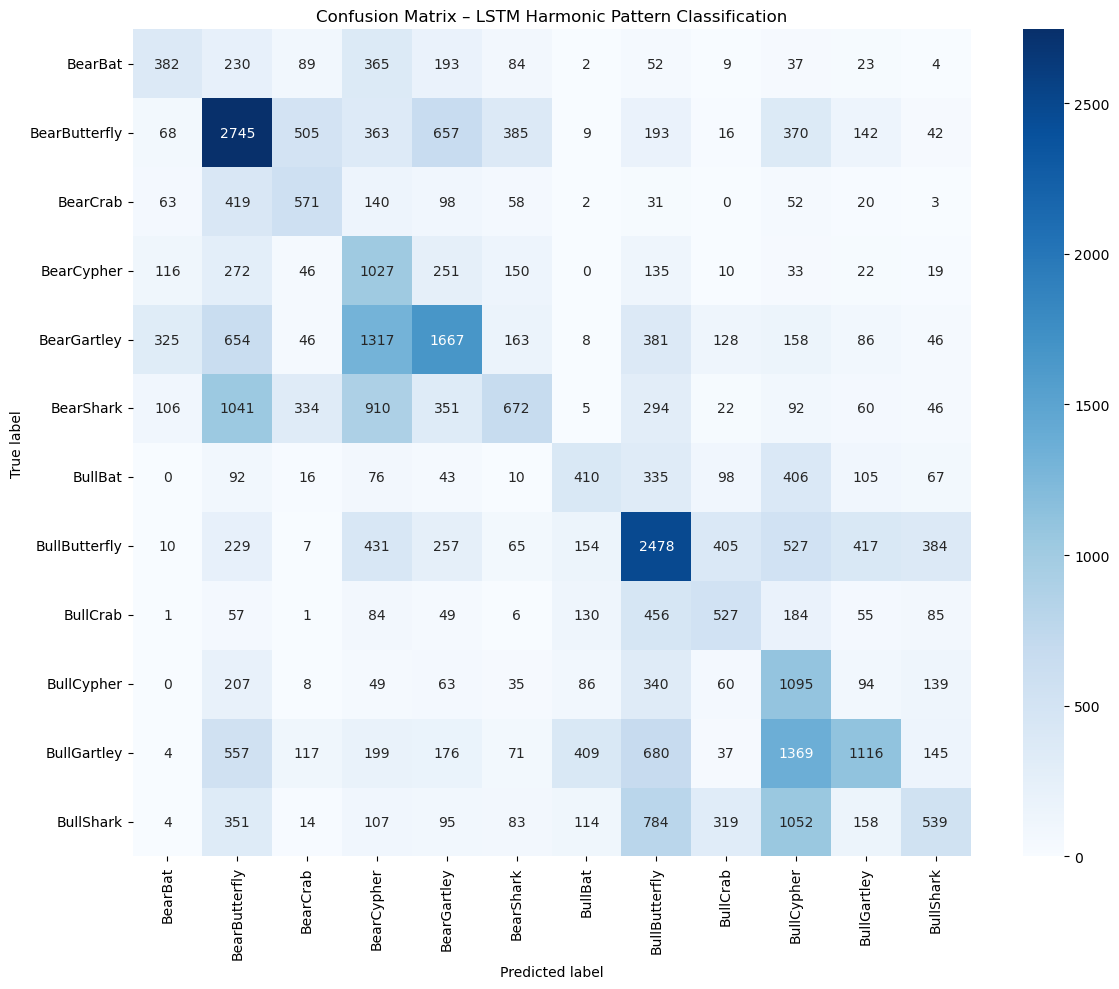

In [14]:
from src.evaluation import (
    build_eval_dataset,
    evaluate_model_multiclass,
    check_train_eval_overlap,
    plot_confusion_matrix
)

X_eval, y_eval = build_eval_dataset(eval_files, load_xy_fn)
print("Eval set:", X_eval.shape, y_eval.shape)

report, cm = evaluate_model_multiclass(model, X_eval, y_eval, CLASSES_12)
print(report)

print("Overlap(train, eval) =", check_train_eval_overlap(train_files, eval_files))

plot_confusion_matrix(cm, CLASSES_12, "Confusion Matrix – LSTM Harmonic Pattern Classification")
